In [2]:
# ============================================================
# Deep Residual Learning for Image Recognition (He et al., 2015)
# CIFAR-10 reproduction in PyTorch
# ============================================================

!pip install torch torchvision matplotlib -q

import math, os
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision, torchvision.transforms as T
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Device:", device)


✅ Device: cuda


In [3]:
# ============================================================
# Data Loading (CIFAR-10) — same preprocessing as in the paper
# ============================================================

BATCH  = 128
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)

def make_loaders(batch=BATCH, workers=2):
    train_tfms = T.Compose([
        T.RandomCrop(32, padding=4),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(CIFAR10_MEAN, (1.0, 1.0, 1.0)),  # mean-only
    ])
    test_tfms = T.Compose([
        T.ToTensor(),
        T.Normalize(CIFAR10_MEAN, (1.0, 1.0, 1.0)),
    ])
    tr = torchvision.datasets.CIFAR10("./data", train=True,  download=True, transform=train_tfms)
    te = torchvision.datasets.CIFAR10("./data", train=False, download=True, transform=test_tfms)
    tl = DataLoader(tr, batch_size=batch, shuffle=True,  num_workers=2, pin_memory=True)
    vl = DataLoader(te, batch_size=batch, shuffle=False, num_workers=2, pin_memory=True)
    return tl, vl

train_loader, test_loader = make_loaders()
print("✅ Data loaded successfully")


100%|██████████| 170M/170M [00:07<00:00, 22.4MB/s]


✅ Data loaded successfully


In [4]:
# ============================================================
# CIFAR-10 ResNet + PlainNet
# ============================================================

def conv3x3(in_c, out_c, stride=1):
    return nn.Conv2d(in_c, out_c, 3, stride=stride, padding=1, bias=False)

def shortcut_option_A(x, out_planes, stride):
    # Option A (no projection): subsample + zero pad
    if stride != 1:
        x = x[:, :, ::2, ::2]
    pad_c = out_planes - x.size(1)
    if pad_c > 0:
        left = pad_c // 2
        right = pad_c - left
        x = F.pad(x, (0,0,0,0,left,right))
    return x

class PlainBlock(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super().__init__()
        self.conv1 = conv3x3(in_c, out_c, stride)
        self.bn1   = nn.BatchNorm2d(out_c)
        self.conv2 = conv3x3(out_c, out_c, 1)
        self.bn2   = nn.BatchNorm2d(out_c)
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = self.bn2(self.conv2(out))
        out = F.relu(out, inplace=True)
        return out

class BasicBlockA(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super().__init__()
        self.conv1 = conv3x3(in_c, out_c, stride)
        self.bn1   = nn.BatchNorm2d(out_c)
        self.conv2 = conv3x3(out_c, out_c, 1)
        self.bn2   = nn.BatchNorm2d(out_c)
        self.in_c, self.out_c, self.stride = in_c, out_c, stride
    def forward(self, x, return_preact=False):
        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        pre = self.bn2(self.conv2(out))   # before addition (Fig.7)
        out = F.relu(pre + shortcut_option_A(x, self.out_c, self.stride), inplace=True)
        return (out, pre) if return_preact else out

class PlainNet(nn.Module):
    def __init__(self, depth=20):
        super().__init__()
        assert (depth-2)%6==0
        n = (depth-2)//6
        self.in_c = 16
        self.conv1 = conv3x3(3,16,1)
        self.bn1   = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(PlainBlock, 16, n, 1)
        self.layer2 = self._make_layer(PlainBlock, 32, n, 2)
        self.layer3 = self._make_layer(PlainBlock, 64, n, 2)
        self.avg = nn.AdaptiveAvgPool2d(1)
        self.fc  = nn.Linear(64,10)
    def _make_layer(self, Block, planes, blocks, stride):
        layers = [Block(self.in_c, planes, stride)]
        self.in_c = planes
        for _ in range(1, blocks): layers.append(Block(self.in_c, planes, 1))
        return nn.Sequential(*layers)
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)), inplace=True)
        x = self.layer1(x); x = self.layer2(x); x = self.layer3(x)
        x = self.avg(x).flatten(1)
        return self.fc(x)

class ResNetCIFAR_A(nn.Module):
    def __init__(self, depth=20):
        super().__init__()
        assert (depth-2)%6==0
        n = (depth-2)//6
        self.in_c = 16
        self.conv1 = conv3x3(3,16,1)
        self.bn1   = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, n, 1)
        self.layer2 = self._make_layer(32, n, 2)
        self.layer3 = self._make_layer(64, n, 2)
        self.avg = nn.AdaptiveAvgPool2d(1)
        self.fc  = nn.Linear(64,10)
    def _make_layer(self, planes, blocks, stride):
        layers = [BasicBlockA(self.in_c, planes, stride)]
        self.in_c = planes
        for _ in range(1, blocks): layers.append(BasicBlockA(self.in_c, planes, 1))
        return nn.ModuleList(layers)
    def forward(self, x, collect_preact=False):
        preacts = []
        x = F.relu(self.bn1(self.conv1(x)), inplace=True)
        for stage in [self.layer1, self.layer2, self.layer3]:
            for blk in stage:
                if collect_preact:
                    x, pre = blk(x, return_preact=True); preacts.append(pre)
                else:
                    x = blk(x, return_preact=False)
        x = self.avg(x).flatten(1)
        out = self.fc(x)
        return (out, preacts) if collect_preact else out


In [5]:
# ============================================================
# Training / Evaluation functions
# ============================================================

LR     = 0.1
MOM    = 0.9
WD     = 1e-4

def adjust_lr(opt, epoch, lr0=LR):
    lr = lr0
    if epoch >= 123: lr *= 0.01
    elif epoch >= 82: lr *= 0.1
    for pg in opt.param_groups: pg["lr"] = lr
    return lr

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    crit = nn.CrossEntropyLoss()
    tot, cor, loss_sum = 0,0,0.
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        out = model(x)
        loss = crit(out,y)
        loss_sum += loss.item()*x.size(0)
        _,pred = out.max(1)
        tot += y.size(0); cor += pred.eq(y).sum().item()
    acc = 100.*cor/tot; err = 100.-acc
    return {"acc":acc, "err":err, "loss":loss_sum/tot}

def train_one_epoch(model, loader, opt):
    model.train()
    crit = nn.CrossEntropyLoss()
    tot, cor, loss_sum = 0,0,0.
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        opt.zero_grad(set_to_none=True)
        out = model(x)
        loss = crit(out,y)
        loss.backward(); opt.step()
        loss_sum += loss.item()*x.size(0)
        _,pred = out.max(1)
        tot += y.size(0); cor += pred.eq(y).sum().item()
    acc = 100.*cor/tot; err = 100.-acc
    return {"acc":acc, "err":err, "loss":loss_sum/tot}


[Plain-20] Epoch 1/2 | train err 70.04% | test err 64.61%
[Plain-20] Epoch 2/2 | train err 58.71% | test err 56.44%
[Plain-56] Epoch 1/2 | train err 87.18% | test err 85.31%
[Plain-56] Epoch 2/2 | train err 82.25% | test err 81.14%


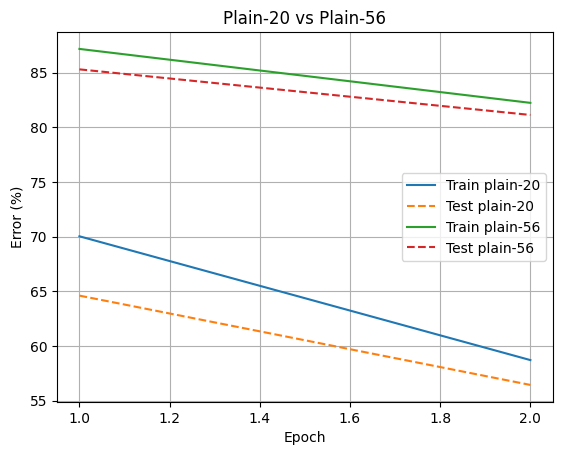

In [6]:
# ============================================================
# Training/Test error comparison (Plain-20 vs 56)
# ============================================================

EPOCHS = 2   # set to 164 for paper accuracy
curves = {}

for d in [20,56]:
    m = PlainNet(d).to(device)
    opt = torch.optim.SGD(m.parameters(), lr=LR, momentum=MOM, weight_decay=WD)
    tr_hist, te_hist = [], []
    for ep in range(1,EPOCHS+1):
        _ = adjust_lr(opt, ep)
        tr = train_one_epoch(m, train_loader, opt)
        te = evaluate(m, test_loader)
        tr_hist.append(tr); te_hist.append(te)
        print(f"[Plain-{d}] Epoch {ep}/{EPOCHS} | train err {tr['err']:.2f}% | test err {te['err']:.2f}%")
    curves[d] = {"tr":tr_hist, "te":te_hist}

plt.figure()
for d in [20,56]:
    plt.plot(range(1,EPOCHS+1), [h["err"] for h in curves[d]["tr"]], label=f"Train plain-{d}")
    plt.plot(range(1,EPOCHS+1), [h["err"] for h in curves[d]["te"]], "--", label=f"Test plain-{d}")
plt.xlabel("Epoch"); plt.ylabel("Error (%)"); plt.title("Plain-20 vs Plain-56")
plt.grid(); plt.legend(); plt.show()


[Depth 20] Plain err=50.36% | ResNet err=44.36%
[Depth 32] Plain err=63.88% | ResNet err=45.00%
[Depth 44] Plain err=70.82% | ResNet err=51.00%
[Depth 56] Plain err=77.28% | ResNet err=58.43%
[Depth 110] Plain err=89.28% | ResNet err=78.32%


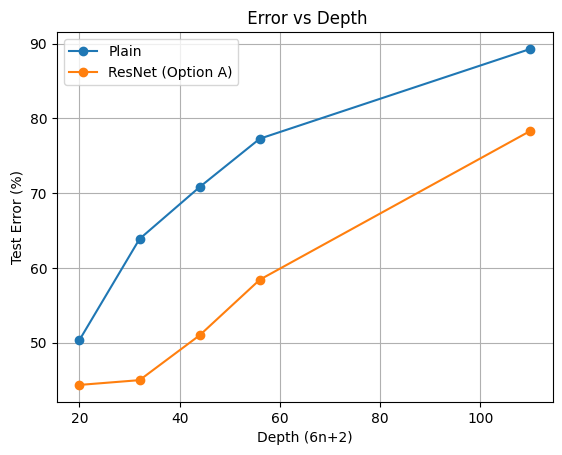

In [7]:
# ============================================================
# Test error vs Depth (Plain vs ResNet)
# ============================================================

DEPTHS = [20, 32, 44, 56, 110]
errs_plain, errs_res = [], []

for d in DEPTHS:
    m = PlainNet(d).to(device)
    opt = torch.optim.SGD(m.parameters(), lr=LR, momentum=MOM, weight_decay=WD)
    for ep in range(1,EPOCHS+1):
        adjust_lr(opt, ep); train_one_epoch(m, train_loader, opt)
    errs_plain.append(evaluate(m, test_loader)["err"])

    r = ResNetCIFAR_A(d).to(device)
    opt = torch.optim.SGD(r.parameters(), lr=LR, momentum=MOM, weight_decay=WD)
    for ep in range(1,EPOCHS+1):
        adjust_lr(opt, ep); train_one_epoch(r, train_loader, opt)
    errs_res.append(evaluate(r, test_loader)["err"])
    print(f"[Depth {d}] Plain err={errs_plain[-1]:.2f}% | ResNet err={errs_res[-1]:.2f}%")

plt.figure()
plt.plot(DEPTHS, errs_plain, "o-", label="Plain")
plt.plot(DEPTHS, errs_res, "o-", label="ResNet (Option A)")
plt.xlabel("Depth (6n+2)"); plt.ylabel("Test Error (%)")
plt.title(" Error vs Depth")
plt.grid(); plt.legend(); plt.show()


Training Plain-20 and ResNet-20 ...
Training Plain-56 and ResNet-56 ...
Training Plain-110 and ResNet-110 ...


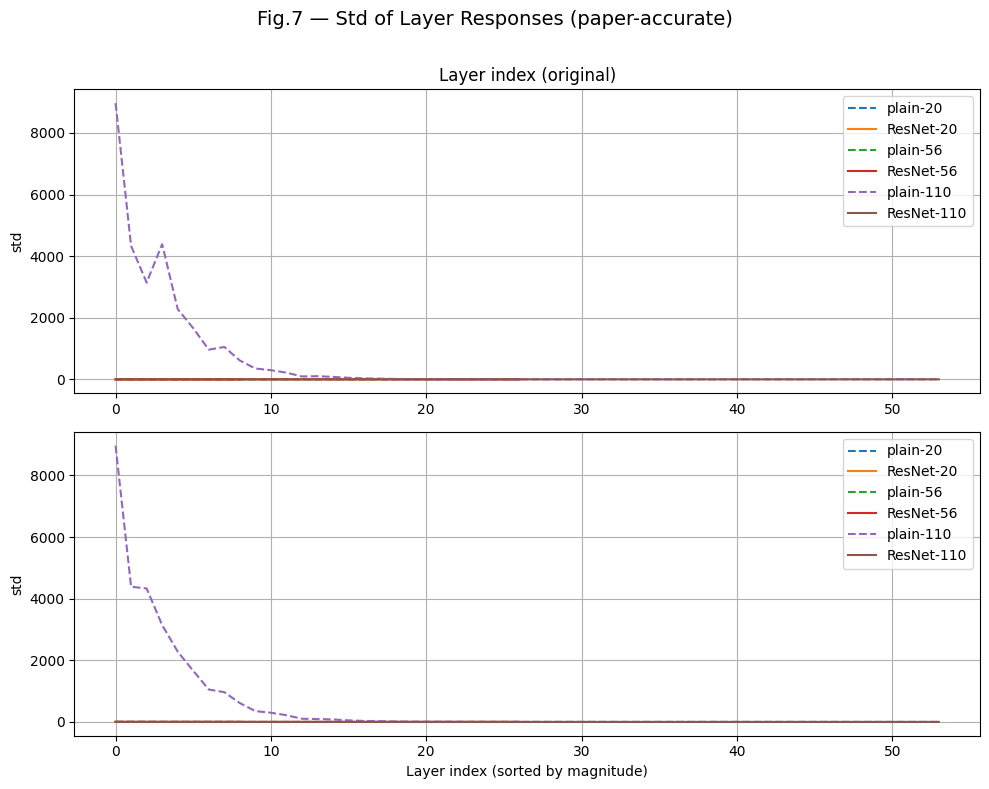

In [8]:
# ============================================================
# Mean std of layer responses per block
# ============================================================

import numpy as np
import torch
import matplotlib.pyplot as plt

def _num_blocks_cifar(depth):
    assert (depth - 2) % 6 == 0
    n = (depth - 2) // 6
    return n * 3  # 3 stages

@torch.no_grad()
def collect_layer_std_plain_meaned(model, loader):
    """PlainNet : std moyenne par bloc (après BN2, avant ReLU), moyennée sur tout le dataset."""
    model.eval()
    # nombre total de blocs
    # (len des bn2 à travers layer1/2/3)
    bn_modules = []
    for stage in [model.layer1, model.layer2, model.layer3]:
        for blk in stage:
            bn_modules.append(blk.bn2)
    nb = len(bn_modules)

    sums = torch.zeros(nb, dtype=torch.float32, device='cpu')
    counts = torch.zeros(nb, dtype=torch.float32, device='cpu')

    # hook qui reçoit un index de bloc
    hooks = []
    def make_hook(idx):
        def hook(_m, _inp, out):
            v = out.detach().float()            # [N,C,H,W]
            s = v.std(dim=(0,2,3)).mean()       # std par canal puis moyenne
            sums[idx]  += s.cpu()
            counts[idx] += 1
        return hook

    for i, bn in enumerate(bn_modules):
        hooks.append(bn.register_forward_hook(make_hook(i)))

    for x,_ in loader:
        _ = model(x.to(device))

    for h in hooks: h.remove()
    means = (sums / counts.clamp_min(1)).numpy()
    return means

@torch.no_grad()
def collect_layer_std_resnetA_meaned(model, loader):
    """ResNet (Option A) : std moyenne par bloc (pré-activation = après BN2, avant addition/ReLU)."""
    model.eval()

    # on doit “synchroniser” les blocs pour savoir combien il y en a
    # en passant une mini-batch et en récupérant la liste des pré-activations
    tmp_x, _ = next(iter(loader))
    _, preacts = model(tmp_x.to(device), collect_preact=True)
    nb = len(preacts)

    sums = torch.zeros(nb, dtype=torch.float32, device='cpu')
    counts = torch.zeros(nb, dtype=torch.float32, device='cpu')

    for x,_ in loader:
        _, preacts = model(x.to(device), collect_preact=True)
        for i, t in enumerate(preacts):         # t: [N,C,H,W]
            s = t.detach().float().std(dim=(0,2,3)).mean()
            sums[i]  += s.cpu()
            counts[i] += 1

    means = (sums / counts.clamp_min(1)).numpy()
    return means

# ---------- Démo rapide (peut rester à 2 époques pour test) ----------
depths = [20, 56, 110]
plain_stats, res_stats = {}, {}

for d in depths:
    print(f"Training Plain-{d} and ResNet-{d} ...")
    # Plain
    p = PlainNet(d).to(device)
    opt = torch.optim.SGD(p.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
    for ep in range(1, 3): adjust_lr(opt, ep); train_one_epoch(p, train_loader, opt)
    plain_stats[d] = collect_layer_std_plain_meaned(p, test_loader)

    # ResNet
    r = ResNetCIFAR_A(d).to(device)
    opt = torch.optim.SGD(r.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
    for ep in range(1, 3): adjust_lr(opt, ep); train_one_epoch(r, train_loader, opt)
    res_stats[d] = collect_layer_std_resnetA_meaned(r, test_loader)


plt.figure(figsize=(10,8))

# (a) ordre original
plt.subplot(2,1,1)
for d in depths:
    plt.plot(plain_stats[d], '--', label=f"plain-{d}")
    plt.plot(res_stats[d],  '-', label=f"ResNet-{d}")
plt.ylabel("std"); plt.title("Layer index (original)")
plt.grid(); plt.legend()

# (b) tri décroissant par réseau
plt.subplot(2,1,2)
for d in depths:
    plt.plot(np.sort(plain_stats[d])[::-1], '--', label=f"plain-{d}")
    plt.plot(np.sort(res_stats[d])[::-1],  '-', label=f"ResNet-{d}")
plt.xlabel("Layer index (sorted by magnitude)")
plt.ylabel("std")
plt.grid(); plt.legend()

plt.suptitle("Fig.7 — Std of Layer Responses (paper-accurate)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
